In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score
import numpy as np
import os
from VisExtract import VisExtract

%matplotlib inline

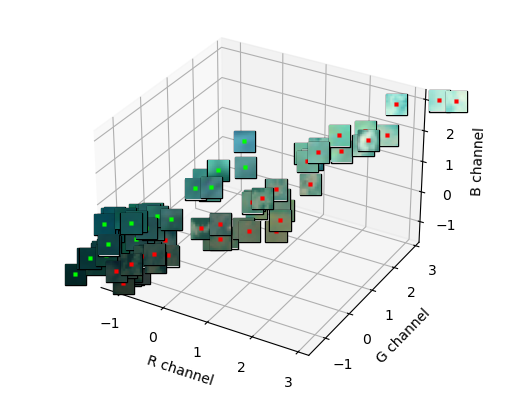

In [9]:
vis = VisExtract('data', 100, 'show')

In [32]:
(trainData, testData, trainLabels, testLabels) = train_test_split(vis.data, vis.y, test_size=0.9, random_state=9)

In [33]:
len(trainData), len(vis.data)

(10, 100)

In [34]:
model = LogisticRegression(random_state=0, solver = 'lbfgs').fit(trainData, trainLabels)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


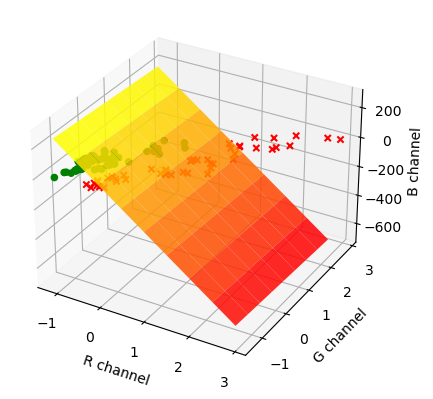

In [35]:
vis.add_hyperplane(list((model.intercept_[0], model.coef_[0][0], model.coef_[0][1], model.coef_[0][2])))

In [36]:
Y_pred = model.predict(testData)

In [37]:
f1_score(Y_pred, testLabels)

0.7466666666666667